In [1]:
import pickle
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston
%matplotlib inline
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from collections import OrderedDict
import gc
from sklearn import datasets, linear_model,preprocessing
from IPython.display import display, HTML
import time
import nltk.corpus
from nltk.stem.snowball import SnowballStemmer

In [2]:
def RMSE(y_true,y_pred):
    mse = np.sqrt(mean_squared_error(y_true, y_pred))
    print 'MSE: %2.3f' % mse
    return mse

In [3]:
#take 1 CSV, then split it to 3..
class FeatureEngineering:

    def __init__(self, ValidationStart, ValidationEnd, trainHdfPath, trainHdfFile, testHdfPath1, testHdfPath2, testHdfFile, 
                 testTypes, trainTypes, trainCsvPath, testCsvPath, maxLag=0):
        self.ValidationStart = ValidationStart
        self.ValidationEnd = ValidationEnd
        self.maxLag = maxLag
        self.trainHdfPath = trainHdfPath
        self.trainHdfFile = trainHdfFile
        self.testHdfPath1 = testHdfPath1
        self.testHdfPath2 = testHdfPath2
        self.testHdfFile = testHdfFile
        self.testTypes = testTypes
        self.trainTypes = trainTypes
        self.trainCsvPath = trainCsvPath
        self.testCsvPath = testCsvPath
        
    @staticmethod
    def __printDataFrameBasics__(data):
        display(data.head(2))
        #print data.dtypes
        gc.collect()
        print(data.info(memory_usage=True))
        
    @staticmethod    
    def changeIndexTypeToLowerMemory(data):
        ##########
        #This is very critical, i accept max number is 2^32. Also, if don't do that, memory gets so much higher..
        ##########
        #data.reset_index(inplace=True)
        #data.drop("index",axis=1, inplace=True)
        #data.index = data.index.astype('uint32')
        gc.collect()
        
    def ReadHdf(self, trainOrTestOrBoth):
        '''Reads and holds Df in object memory'''            
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train = pd.read_hdf(self.trainHdfPath,self.trainHdfFile)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
            
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1 = pd.read_hdf(self.testHdfPath1,self.testHdfFile)
            self.test2 = pd.read_hdf(self.testHdfPath2,self.testHdfFile)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
        
    def ReadCsv(self, trainOrTestOrBoth):
        '''Reads and holds Df in memory'''
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth == 'both':
            self.train = pd.read_csv(self.trainCsvPath, usecols=self.trainTypes.keys(), dtype=self.trainTypes)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            tempTest = pd.read_csv(self.testCsvPath, usecols=self.testTypes.keys(), dtype=self.testTypes)
            self.test1 = tempTest.loc[tempTest.Semana.values == self.ValidationStart]
            self.test2 = tempTest.loc[tempTest.Semana.values == self.ValidationEnd]
            del tempTest
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
            
    @staticmethod
    def ConvertCsvToHdf(csvPath, HdfPath, HdfName, ColumnTypeDict ):
        tempDf = pd.read_csv(csvPath, usecols=ColumnTypeDict.keys(), dtype=ColumnTypeDict,index=False)
        tempDf.to_hdf(HdfPath, HdfName, format='t')
        del tempDf
        gc.collect()
        print "ConvertCsvToHdf is done.."

    def Preprocess(self, trainOrTestOrBoth, columnFunctionTypeList):
        '''columnFunctionTypeList = [ ['C1',Func1,Type], ['C2',Func2,Type],..    ]'''
        for column, func, localType in columnFunctionTypeList:
            if trainOrTestOrBoth == 'train' or trainOrTestOrBoth =='both':
                self.train.loc[:,column] =  np.apply_along_axis(func,0,FE.train[column].values).astype(localType)
                #np.apply_along_axis(lambda x: x+1,0,FE.train["Semana"]).astype("int32")
            if trainOrTestOrBoth == 'test' or trainOrTestOrBoth == 'both':
                self.test1.loc[:,column] =  np.apply_along_axis(func,0,FE.test1[column].values).astype(localType)
                self.test2.loc[:,column] =  np.apply_along_axis(func,0,FE.test2[column].values).astype(localType)
        gc.collect()
        
    def SaveDataFrameToHdf(self,trainOrTestOrBoth):
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train.to_hdf(self.trainHdfPath, self.trainHdfFile, format='t', index="False")
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1.to_hdf(self.testHdfPath1, self.testHdfFile, format='t', index="False")
            self.test2.to_hdf(self.testHdfPath2, self.testHdfFile, format='t', index="False")
        
    def AddDemandaGeneralMean(self,trainOrTestOrBoth): 
        #self.train.loc[:,"DemandaGeneralMean"] = self.train["Demanda_uni_equil"].loc[
         #   self.train.loc[:,'Semana'] < 10].mean().astype("float32")
            
        meanOfDemanda = self.train["Demanda_uni_equil"].values.mean().astype("float32")
        
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train.loc[:,"DemandaGeneralMean"] = meanOfDemanda
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1.loc[:,"DemandaGeneralMean"] = meanOfDemanda
            self.test2.loc[:,"DemandaGeneralMean"] = meanOfDemanda
        
        #self.train.loc[:,"DemandaGeneralMean"] = self.train["Demanda_uni_equil"].values[
        #(self.train.loc[:,'Semana'].values < self.ValidationStart).values].mean().astype("float32")
        gc.collect()
        
    '''ConfigElements(0,[ ("A",["Semana","Agencia_ID"],["count","count"]),'''
    def AddConfigurableFeaturesToTrain(self, config):
        if config.lag > self.maxLag:
            self.maxLag = config.lag
        
        tempData = self.train[self.train['Semana'].values <= (self.ValidationEnd - config.lag)]
        #display(tempData)
        if(config.lag != 0):
            tempData.loc[:,'Semana'] = tempData['Semana'].values + config.lag
        #display(tempData)
        
        #Means iterative.. eliminate as long as np.nan exists..If there is already one, don't create, use the existing
        if config.targetVariable != "" and  config.targetVariable not in self.train.columns:
            self.train.loc[:,config.targetVariable] = np.nan
            self.test1.loc[:,config.targetVariable] = np.nan
            
            if config.lag != 1:
                self.test2.loc[:,config.targetVariable] = np.nan
        
        for name,groups,aggregate in config.nameAndGroups:
            if name not in self.train.columns:
                print "{} is not in columns..".format(name)            
                
                groupedDataframe = tempData[groups+['Demanda_uni_equil']].copy().groupby(groups).agg(aggregate[0])
                gc.collect()
                #groupedDataframe.columns = groupedDataframe.columns.droplevel(0)
                groupedDataframe.columns = [name]
                
                #This is means of the counts of the semana-columns tuples!..!!!
                #If no lag and mean, mean of the columns without semana!!..
                #If there is lag and count, count of the columns x weeks before
                #If there is lag and mean, mean of the columns x weeks before
                #if(config.lag == 0 and aggregate == "count"):
                if(len(aggregate)>1):
                    groupedDataframe.reset_index(inplace=True)
                    groupedDataframe.drop("Semana",axis=1, inplace=True)
                    groups = groups[1:]
                    groupedDataframe = groupedDataframe.groupby(groups).agg(aggregate[1])
                    groupedDataframe.columns = [name]
                    gc.collect()
                
                display(groupedDataframe)
                self.train = self.train.merge( groupedDataframe, left_on=groups,
                    right_index=True, how='left', sort=False,copy=False)
                gc.collect()
                self.test1 = self.test1.merge( groupedDataframe, left_on=groups,
                    right_index=True, how='left', sort=False,copy=False)
                gc.collect()
                if config.lag != 1:
                    self.test2 = self.test2.merge( groupedDataframe, left_on=groups,
                        right_index=True, how='left', sort=False,copy=False)
                
                del groupedDataframe
                gc.collect()
            else:
                print "{} is in columns..".format(name)
            
            display(self.train)
            display(self.test1)
            display(self.test2)
            
            #Means iterative..!!!!!
            if config.targetVariable != "":
                self.train.loc[pd.isnull(self.train[config.targetVariable].values), 
                    config.targetVariable] = self.train.loc[pd.isnull(self.train[config.targetVariable].values)
                    , name].values
                self.test1.loc[pd.isnull(self.test1[config.targetVariable].values), 
                    config.targetVariable] = self.test1.loc[pd.isnull(self.test1[config.targetVariable].values),
                    name].values
                if config.lag != 1:
                    self.test2.loc[pd.isnull(self.test2[config.targetVariable].values), 
                        config.targetVariable] = self.test2.loc[pd.isnull(self.test2[config.targetVariable].values)
                        , name].values
                    
                count = self.test1[config.targetVariable].isnull().sum()
                print "Count of missing numbers after {} in validation part 1 in column {} is {}".format(name, 
                    config.targetVariable,str(count))
                if config.lag != 1:
                    count = self.test2.loc[:,config.targetVariable].isnull().sum()
                    print "Count of missing numbers after {} in validation part 2 in column {} is {}".format(name, 
                        config.targetVariable,str(count))
                
                
                #display(self.train)
                #If column is already in Dataframe and we want to fill target variable, this deletes columns!!!
                if(config.deleteColumns):
                    self.train.drop(name, axis=1, inplace=True)
                    self.test1.drop(name, axis=1, inplace=True)
                    if config.lag != 1:
                        self.test2.drop(name, axis=1, inplace=True)
                gc.collect()
                #Only in tesst
                #if count == 0:
                 #   break
        del tempData
        display(self.train)   
        display(self.test1)   
        display(self.test2)
        gc.collect()
        return 
    
    def DeleteLaggedWeeksFromTrain(self):
        self.train = self.train[self.train['Semana'].values >= (3 + self.maxLag)]
        gc.collect()
        display(self.train.head(2))
        
    def ReadFirstNRowsOfACsv(self, nrows, trainOrTestOrBoth) :
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train = pd.read_csv(self.trainCsvPath, usecols=self.trainTypes.keys(), dtype=self.trainTypes, nrows = nrows)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            tempTest = pd.read_csv(self.testCsvPath, usecols=self.testTypes.keys(), dtype=self.testTypes, nrows = nrows*2)
            self.test1 = tempTest.loc[tempTest.Semana == self.ValidationStart]
            self.test2 = tempTest.loc[tempTest.Semana == self.ValidationEnd]
            del tempTest
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
    
    #Use when concatanating train and validation before predict test for example..
    def AppendTestToTrain(self,deleteTest = True):
        self.train = self.train.append(self.test1,ignore_index=True)
        gc.collect()
        if(deleteTest):
            del self.test1
            gc.collect()
        try:
            self.train = self.train.append(self.test2,ignore_index=True)
            gc.collect()
            if(deleteTest):
                del self.test2
                gc.collect()
        except:
            pass
        #BAD PERFORMANCE!!
    #Split train data to train and test1 and test2 (validation)
    #def SplitTrainToTestUsingValidationStart(self):
     #   boolCondition = self.train.Semana == self.ValidationStart
      #  self.test1 = self.train.loc[boolCondition]
       # self.train.drop((self.train.loc[boolCondition].index), axis=0,inplace=True)
        
       # boolCondition = self.train.Semana == self.ValidationEnd
       # self.test2 = self.train.loc[boolCondition]
       # self.train.drop((self.train.loc[boolCondition].index), axis=0,inplace=True)
      #  del boolCondition
      #  gc.collect()
    
    #Reaches 3x memory from train, because of test1, test2 and train itself at the end.. GC fixed in the end..
    def SplitTrainToTestUsingValidationStart(self):
        boolCondition = self.train.Semana.values == self.ValidationStart
        self.test1 = self.train[boolCondition]
        boolCondition = self.train.Semana.values == self.ValidationEnd
        self.test2 = self.train[boolCondition]
        FE.train = FE.train[ FE.train.Semana.values < FE.ValidationStart ]
        del boolCondition
        gc.collect()
        
    def XgboostPredictAndSee(self, Test1OrTest2):
        self.train_y = self.train["Demanda_uni_equil"].copy()
        self.train.drop("Demanda_uni_equil",axis=1, inplace=True)
        

In [4]:
parameterDict =       {"ValidationStart":8, 
 "ValidationEnd":9,
   "maxLag":3,
    "trainHdfPath":'../../input/train.h5',
    "trainHdfFile":"train",
    "testHdfPath1":"../../input/test1.h5",
    "testHdfPath2":"../../input/test2.h5",
    "testHdfFile":"test", 
    "trainTypes" : {'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16, 
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint16, 'Venta_hoy':np.float32,
                    'Dev_uni_proxima': np.uint32, 'Dev_proxima':np.float32,'Demanda_uni_equil':np.uint32}, 
    "testTypes" : {'id':np.uint32,'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16,
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16},
    "trainCsvPath":'../../input/train.csv'   ,
    "testCsvPath":'../../input/test.csv'}

FE = FeatureEngineering(**parameterDict)
print FE.__dict__

{'trainCsvPath': '../../input/train.csv', 'maxLag': 3, 'testTypes': {'Cliente_ID': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Semana': <type 'numpy.uint8'>, 'id': <type 'numpy.uint32'>}, 'testHdfFile': 'test', 'trainTypes': {'Dev_proxima': <type 'numpy.float32'>, 'Venta_uni_hoy': <type 'numpy.uint16'>, 'Cliente_ID': <type 'numpy.uint32'>, 'Demanda_uni_equil': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Venta_hoy': <type 'numpy.float32'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Dev_uni_proxima': <type 'numpy.uint32'>, 'Semana': <type 'numpy.uint8'>}, 'testHdfPath1': '../../input/test1.h5', 'ValidationEnd': 9, 'testHdfPath2': '../../input/test2.h5', 'testCsvPath': '../../input/test.csv', 'ValidationStart': 8, 'trainHdfFile': 'train', 'trainHdfPath': '../../input/train.h5'}


In [5]:
FE.ReadHdf('both')

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.0,...,4204,0.0,114,0.0,4349.0,874944,0.004971,7621.0,1485279,0.005131
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.0,...,4204,0.0,114,0.0,3166.0,756981,0.004182,5209.0,1243038,0.004191


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53165116 entries, 0 to 53165115
Data columns (total 46 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,8,1110,7,3301,15766,1212,4,33.520000,0,0.0,...,4204,0.0,114.0,0.0,4349.0,874944.0,0.004971,7621.0,1485279.0,0.005131
1,8,1110,7,3301,15766,1216,5,41.900002,0,0.0,...,4204,0.0,114.0,0.0,3166.0,756981.0,0.004182,5209.0,1243038.0,0.004191


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10406868 entries, 0 to 10406867
Data columns (total 45 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,9,1110,7,3301,15766,1212,1,8.38,0,0.0,...,4204,0.0,114.0,0.0,4349.0,874944.0,0.004971,7621.0,1485279.0,0.005131
1,9,1110,7,3301,15766,1238,2,19.66,0,0.0,...,4204,0.0,114.0,0.0,4350.0,877130.0,0.004959,4981.0,999101.0,0.004985


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10408713 entries, 0 to 10408712
Data columns (total 44 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

In [6]:
FE.DeleteLaggedWeeksFromTrain()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
32671538,6,1110,7,3301,15766,1216,1,8.38,0,0.0,...,4204,0.0,114,0.0,3166.0,756981,0.004182,5209.0,1243038,0.004191
32671539,6,1110,7,3301,15766,1238,2,19.66,0,0.0,...,4204,0.0,114,0.0,4350.0,877130,0.004959,4981.0,999101,0.004985


In [7]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

In [8]:
columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
                    'producto_return_rate', 'producto_return_count']

In [9]:
test2columns = list ( set(test2columns) - set(columns_to_remove))

In [10]:
test1columns = test2columns + ['Lag1']

In [11]:
FE.test1.head(2)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,8,1110,7,3301,15766,1212,4,33.520000,0,0.0,...,4204,0.0,114.0,0.0,4349.0,874944.0,0.004971,7621.0,1485279.0,0.005131
1,8,1110,7,3301,15766,1216,5,41.900002,0,0.0,...,4204,0.0,114.0,0.0,3166.0,756981.0,0.004182,5209.0,1243038.0,0.004191


In [12]:
X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]

In [13]:
gc.collect()

696

In [14]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(20493578, 25)
(10406868, 25)
(20493578,)
(10406868,)


In [15]:
display(X_train[:3])
display(X_test[:3])
display(y_train[:3])
display(y_test[:3])

,weight,Producto_sum_Venta_hoy,pieces,producto_return_sum,prod_name_sum_Venta_hoy,Producto_sum_Venta_uni_hoy,Prod_name_ID_sum_demanda_divide_sum_venta_uni,Cliente_ID_sum_demanda_divide_sum_venta_uni,Client_return_rate,prod_name_return_rate,...,State_ID,prod_name_return_count,ClientPerTown,prod_name_return_sum,Client_Sum_venta_div_venta_uni,prod_name_sum_venta_div_venta_uni,Brand_ID,weightppieces,Producto_ID_sum_demanda_divide_sum_venta_uni,Lag1
32671538,135,20126136.0,2,3166.0,42279768.0,2396759.0,0.983903,0.996855,0.0,0.004191,...,16,1243038,4204,5209.0,6.84217,10.430708,4,67,0.985235,1.386294
32671539,140,28693384.0,2,4350.0,32648700.0,2881029.0,0.984168,0.996855,0.0,0.004985,...,16,999101,4204,4981.0,6.84217,9.990899,4,70,0.984176,0.693147
32671540,105,59257060.0,6,4052.0,72890592.0,7734233.0,0.992678,0.996855,0.0,0.002717,...,16,1756822,4204,4774.0,6.84217,7.689684,4,17,0.993033,1.098612


,weight,Producto_sum_Venta_hoy,pieces,producto_return_sum,prod_name_sum_Venta_hoy,Producto_sum_Venta_uni_hoy,Prod_name_ID_sum_demanda_divide_sum_venta_uni,Cliente_ID_sum_demanda_divide_sum_venta_uni,Client_return_rate,prod_name_return_rate,...,State_ID,prod_name_return_count,ClientPerTown,prod_name_return_sum,Client_Sum_venta_div_venta_uni,prod_name_sum_venta_div_venta_uni,Brand_ID,weightppieces,Producto_ID_sum_demanda_divide_sum_venta_uni,Lag1
0,120,21736028.0,2,4349.0,50557572.0,2596974.0,0.980954,0.996855,0.0,0.005131,...,16,1485279.0,4204,7621.0,6.84217,11.627322,4,60,0.982730,1.499550
1,135,20126136.0,2,3166.0,42279768.0,2396759.0,0.983903,0.996855,0.0,0.004191,...,16,1243038.0,4204,5209.0,6.84217,10.430708,4,67,0.985235,1.098612
2,130,15941300.0,6,1774.0,16905576.0,2089770.0,0.988285,0.996855,0.0,0.002786,...,16,683425.0,4204,1904.0,6.84217,7.630471,4,21,0.988840,1.438280


32671538    0.693147
32671539    1.098612
32671540    1.386294
Name: Demanda_uni_equil, dtype: float64

0    1.609438
1    1.791759
2    0.693147
Name: Demanda_uni_equil, dtype: float64

17:22

[0]	validation_0-rmse:1.27086	validation_1-rmse:1.2672
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16558	validation_1-rmse:1.16292
[2]	validation_0-rmse:1.05781	validation_1-rmse:1.06141
[3]	validation_0-rmse:0.973973	validation_1-rmse:0.98004
[4]	validation_0-rmse:0.901094	validation_1-rmse:0.908973
[5]	validation_0-rmse:0.822385	validation_1-rmse:0.839006
[6]	validation_0-rmse:0.766812	validation_1-rmse:0.785952
[7]	validation_0-rmse:0.7034	validation_1-rmse:0.732897
[8]	validation_0-rmse:0.649046	validation_1-rmse:0.687595
[9]	validation_0-rmse:0.60142	validation_1-rmse:0.649337
[10]	validation_0-rmse:0.557952	validation_1-rmse:0.617257
[11]	validation_0-rmse:0.528604	validation_1-rmse:0.592289
[12]	validation_0-rmse:0.50698	validation_1-rmse:0.574291
[13]	validation_0-rmse:0.478081	validation_1-rmse:0.554935
[14]	validation_0-rmse:0.453307	valid

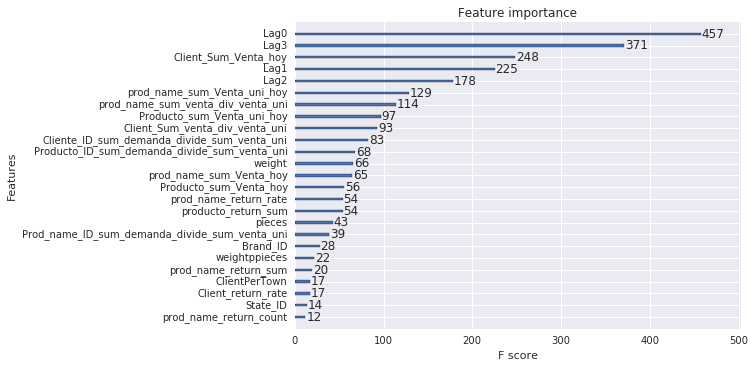

In [16]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model = xgb.XGBRegressor(**defaultParams) 


xgb_model.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model.predict(X_train,ntree_limit  = xgb_model.best_iteration+1)
predictionsTest = xgb_model.predict(X_test,ntree_limit  = xgb_model.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model.best_iteration
print "Best Score: ", xgb_model.best_score
print xgb.plot_importance(xgb_model)

In [33]:
corrDf = FE.train.corr()

In [34]:
corrDf.to_csv('../../input/coordf.csv')

In [35]:
corrDf.loc[:,0:16]

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
Semana,1.000000,-0.002533,0.002695,-0.002468,0.000991,0.001612,0.003190,0.001051,0.000970,0.001008,...,0.005164,-0.000353,-0.000571,-0.000459,-0.001110,-0.005186,-0.006730,0.004978,0.004683,-0.007071
Agencia_ID,-0.002533,1.000000,-0.041674,-0.008482,0.015732,0.004079,-0.005931,-0.007150,-0.001508,-0.002014,...,-0.176519,-0.005401,-0.005806,-0.000841,-0.015891,-0.019472,-0.000680,-0.003560,-0.003374,-0.003483
Canal_ID,0.002695,-0.041674,1.000000,0.473844,0.056699,0.031608,0.130023,0.104950,0.027340,0.027985,...,-0.056065,0.101025,0.100375,0.003185,-0.097315,-0.110599,0.018893,-0.040202,-0.042585,0.016964
Ruta_SAK,-0.002468,-0.008482,0.473844,1.000000,0.061898,0.279722,0.047956,0.023724,0.002750,-0.004477,...,-0.076178,0.024401,0.025693,-0.025058,-0.240984,-0.276817,-0.001847,-0.185595,-0.213785,0.012673
Cliente_ID,0.000991,0.015732,0.056699,0.061898,1.000000,-0.000370,-0.011463,-0.010628,-0.003757,-0.004714,...,-0.006302,-0.020701,-0.023489,-0.001658,0.011586,0.014793,-0.008912,0.021679,0.025869,-0.008338
Producto_ID,0.001612,0.004079,0.031608,0.279722,-0.000370,1.000000,0.045270,0.017864,0.011984,0.008179,...,-0.116016,0.019673,0.021041,-0.007815,-0.363467,-0.537864,0.077547,-0.236622,-0.376132,0.095546
Venta_uni_hoy,0.003190,-0.005931,0.130023,0.047956,-0.011463,0.045270,1.000000,0.733138,0.102037,0.113003,...,-0.038084,0.261434,0.263809,0.012576,-0.058317,-0.050175,0.008423,0.003532,0.029080,0.009992
Venta_hoy,0.001051,-0.007150,0.104950,0.023724,-0.010628,0.017864,0.733138,1.000000,0.068384,0.102692,...,-0.037803,0.136724,0.138708,0.007870,-0.051827,-0.052958,-0.003561,-0.015210,-0.000032,-0.000432
Dev_uni_proxima,0.000970,-0.001508,0.027340,0.002750,-0.003757,0.011984,0.102037,0.068384,1.000000,0.804083,...,-0.007179,0.141175,0.139123,0.109009,-0.007191,-0.015576,0.066156,-0.001574,-0.008449,0.047029
Dev_proxima,0.001008,-0.002014,0.027985,-0.004477,-0.004714,0.008179,0.113003,0.102692,0.804083,1.000000,...,-0.012107,0.126453,0.124477,0.101246,-0.011239,-0.019439,0.057529,-0.004313,-0.009524,0.039973


In [30]:
def GiveBestParameterWithoutCV(defaultParams, testParams, X_train, X_test, Y_train, Y_test, fitParams):
    xgb_model = xgb.XGBRegressor(**defaultParams) 
    
    minRmse = 10000
    minRmseParameter = 10000
    bestIteration = 1000
        
    for key,values in testParams:
        minRmseParameter = xgb_model.get_xgb_params()[key]
        
        for value in values:
            
            xgb_model.set_params(**{key:value})
            xgb_model.fit(X_train,Y_train, eval_set=[(X_train, Y_train),(X_test, Y_test)],
                  **fitParams)
            if xgb_model.best_score < minRmse:
                minRmse = xgb_model.best_score
                minRmseParameter = value
                bestIteration = xgb_model.best_iteration
                
        xgb_model.set_params(**{key:minRmseParameter})
        print "Parameters are finished for {}. Best Iteration is {}".format(key, bestIteration)
        print "Minimum Rmse : {}, optimum parameter is {} between {}".format(minRmse, minRmseParameter, values)
    gc.collect()

In [31]:
defaultParams = {"max_depth":10, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
testParams = [("max_depth",[12,8,6,14]), ("subsample",[0.9,0.8,0.6]), ("min_child_weight",[1,3,7]),
                  ("colsample_bytree",[0.3,0.5,0.6, 0.8,1]), ("learning_rate",[0.05])]
fitParams = {"verbose":2, "early_stopping_rounds": 10}

GiveBestParameterWithoutCV(defaultParams,testParams, X_train, X_test, y_train, y_test, fitParams )

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
[0]	validation_0-rmse:1.26849	validation_1-rmse:1.26704
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:0.575322	validation_1-rmse:0.621886
[20]	validation_0-rmse:0.387544	validation_1-rmse:0.489524


KeyboardInterrupt: 

In [21]:
pd.DataFrame([np.round(np.expm1(predictionsTest[:20])),np.round(np.expm1(y_test[0:20]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.0,2.0,3.0,2.0,5.0,3.0,5.0,4.0,5.0,8.0,3.0,7.0,5.0,6.0,8.0,3.0,3.0,7.0,8.0,5.0
1,4.0,5.0,1.0,3.0,2.0,1.0,8.0,3.0,2.0,17.0,3.0,8.0,9.0,4.0,2.0,4.0,2.0,15.0,6.0,5.0


In [18]:
np.sqrt(mean_squared_error(y_test, predictionsTest))

0.47818887962557871

In [28]:
berker = pd.DataFrame( {"Predict": np.round(np.expm1(predictionsTest)),
    "Real" : np.round(np.expm1(y_test))})

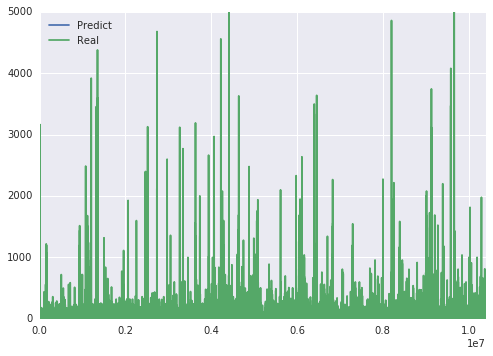

In [29]:
berker.plot()

In [23]:
np.mean(predictionsTest)

1.583607

In [24]:
np.mean(y_test)

1.6004740519086833

In [ ]:
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(xgb_model, open("best_boston.pkl", "wb"))